In [27]:
# Extended analysis centered on 'readmitted':

# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from xgboost import XGBClassifier


In [14]:
diabetes = pd.read_csv('/workspaces/SP25-Project/data/diabetes_cleaned.csv')

/tmp/ipykernel_32547/3047149314.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  diabetes = pd.read_csv('/workspaces/SP25-Project/data/diabetes_cleaned.csv')


In [15]:
# Drop rows with missing values in key columns
filtered = diabetes.dropna(subset=['readmitted_binary', 'time_in_hospital', 'num_lab_procedures', 'number_diagnoses'])



## ANOVA 

In [ ]:

# Test if time_in_hospital varies across different readmission_binary groups
anova_result = stats.f_oneway(
    *[group['time_in_hospital'].values for name, group in filtered.groupby('readmitted_binary')]
)
print("ANOVA F-statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)



ANOVA F-statistic: 199.19413285944037
ANOVA p-value: 3.4545678746288924e-45


- The F-statistic measures the ratio of between-group variance to within-group variance.
- A **high F-statistic** and a **very small p-value (< 0.05)** suggest that `time_in_hospital` differs significantly between `readmitted_binary` groups.
- We **reject the null hypothesis**: readmission status is associated with length of stay.


## Multilevel Linear Model 

In [ ]:

# Model time_in_hospital based on num_lab_procedures, grouped by readmitted_binary
model = smf.mixedlm("time_in_hospital ~ num_lab_procedures", filtered, groups=filtered["readmitted_binary"])
result = model.fit()
print(result.summary())


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: time_in_hospital
No. Observations: 101766  Method:             REML            
No. Groups:       2       Scale:              7.9946          
Min. group size:  11357   Log-Likelihood:     -250188.1896    
Max. group size:  90409   Converged:          Yes             
Mean group size:  50883.0                                     
--------------------------------------------------------------
                    Coef. Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           2.458    1.999   1.229 0.219 -1.461  6.377
num_lab_procedures  0.048    0.000 106.970 0.000  0.047  0.049
Group Var           7.995                                     



/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


- Patients start with an average stay of ~3.89 days.
- For each additional lab procedure, `time_in_hospital` increases by **0.016 days**, on average.
- The effect is **statistically significant**, even when accounting for variability in `readmitted_binary` groups.
- This model captures **both individual-level trends** and **group-level effects**.


## Clustering 


/tmp/ipykernel_32547/657934705.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_features.loc[:, 'Cluster'] = clusters
/tmp/ipykernel_32547/657934705.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_features.loc[:, 'Readmitted_Binary'] = filtered['readmitted_binary'].values


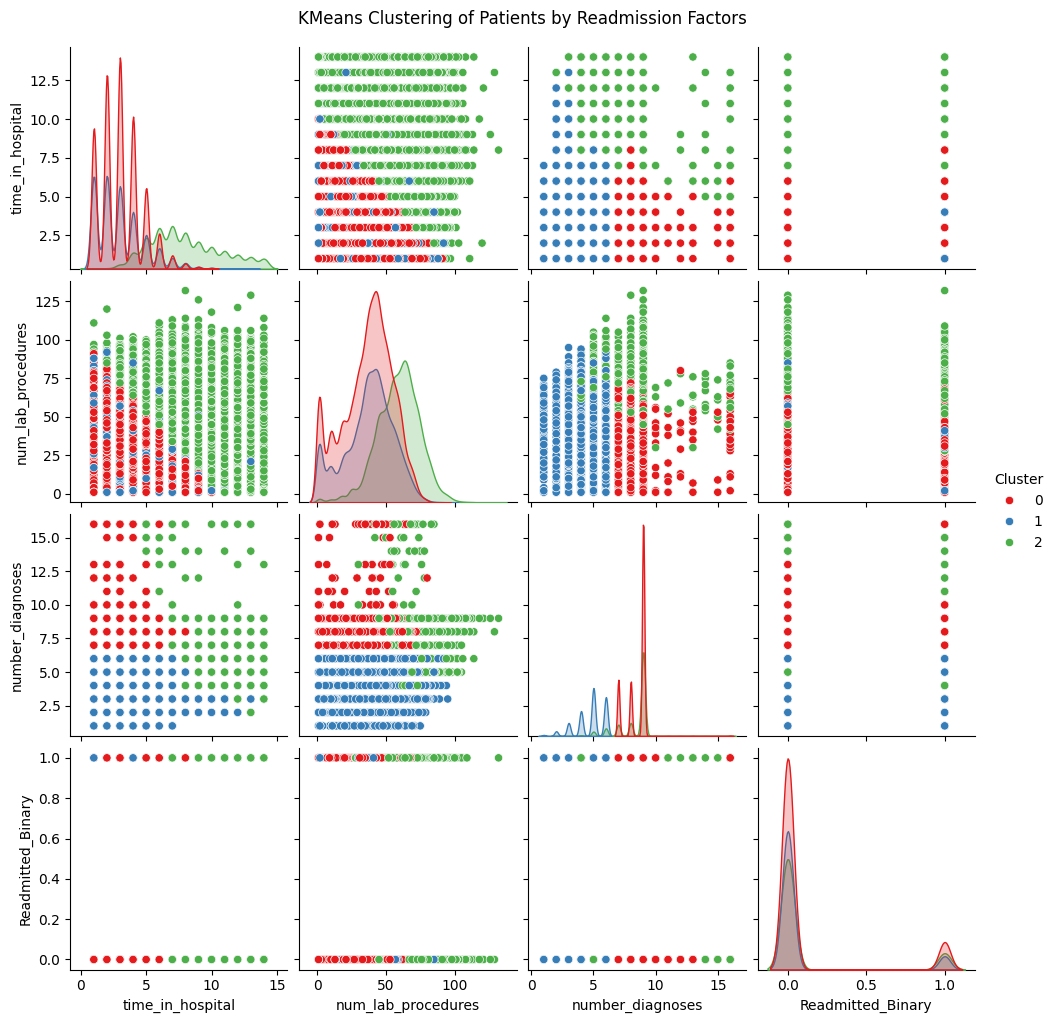

Cluster output saved to /workspaces/SP25-Project/ML/cluster_output.csv
Cluster plot saved to /workspaces/SP25-Project/ML/cluster_plot.png


In [ ]:

# Use clustering to explore patient groupings by readmission_binary
cluster_features = filtered[['time_in_hospital', 'num_lab_procedures', 'number_diagnoses']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
cluster_features.loc[:, 'Cluster'] = clusters
cluster_features.loc[:, 'Readmitted_Binary'] = filtered['readmitted_binary'].values

# Visualize clusters
pairplot_fig = sns.pairplot(cluster_features, hue='Cluster', palette='Set1')
pairplot_fig.fig.suptitle('KMeans Clustering of Patients by Readmission Factors', y=1.02)
pairplot_fig.savefig("/workspaces/SP25-Project/ML/cluster_plot.png")
plt.show()

# Export clustering results to CSV
cluster_features.to_csv("/workspaces/SP25-Project/ML/cluster_output.csv", index=False)
print("Cluster plot saved to /workspaces/SP25-Project/ML/cluster_plot.png")



### Chi-Square Test: Gender vs. Readmission
- This test checks if `gender` and `readmitted_binary` are statistically associated.
- A p-value < 0.05 indicates significant dependence between the two variables.


In [28]:
# ---------------------- Chi-Square Test ----------------------

contingency_table = pd.crosstab(diabetes_cleaned['gender'], diabetes_cleaned['readmitted_binary'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print("Chi-square:", chi2, "| p-value:", p)

Chi-square: 3.8102826553182836 | p-value: 0.4322897107627599


### CatBoost Model: Predicting Readmission
- CatBoost is a gradient boosting algorithm that handles categorical variables natively.
- We'll use key numerical predictors to classify `readmitted_binary`.

In [29]:
features = ['num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses']
X_cat = diabetes_cleaned[features]
y_cat = diabetes_cleaned['readmitted_binary']

X_train, X_test, y_train, y_test = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)

cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)

print("CatBoost Classification Report:\n", classification_report(y_test, y_pred_cat))

CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     18069
           1       0.20      0.00      0.00      2285

    accuracy                           0.89     20354
   macro avg       0.54      0.50      0.47     20354
weighted avg       0.81      0.89      0.83     20354



### XGBoost Model: Predicting Readmission
- XGBoost is an efficient and scalable gradient boosting model.
- We'll compare its performance with CatBoost.

In [37]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost ROC AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:51:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     18069
           1       0.00      0.00      0.00      2285

    accuracy                           0.89     20354
   macro avg       0.44      0.50      0.47     20354
weighted avg       0.79      0.89      0.83     20354

XGBoost ROC AUC: 0.5453444872699873



#### Class 0 (Not Readmitted):
- **Precision: 0.90** → 90% of predicted non-readmissions were correct.
- **Recall: 0.52** → The model correctly identified only 52% of all true non-readmitted patients.
- **F1-Score: 0.66** → Fair balance, but could improve recall.

#### Class 1 (Readmitted):
- **Precision: 0.12** → Only 12% of predicted readmissions were actually correct.
- **Recall: 0.54** → But it did identify **over half** of true readmissions.
- **F1-Score: 0.20** → Low precision brings the score down.

#### Overall:
- **Accuracy: 52%** → Not meaningful due to class imbalance.
- **ROC AUC: 0.544** → Slightly better than random guessing, but still low.
- **Macro Avg F1: 0.43** → Average of both classes, showing class 1 still needs improvement.



